<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Hands on Lab: Complete the Machine Learning Prediction lab


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


In [1]:
import piplite
await piplite.install(['numpy'])
await piplite.install(['pandas'])
await piplite.install(['seaborn'])


We will import the following libraries for the lab


In [2]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

<ipython-input-2-b7d446354769>:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


This function is to plot the confusion matrix.


In [3]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

## Load the dataframe


Load the data


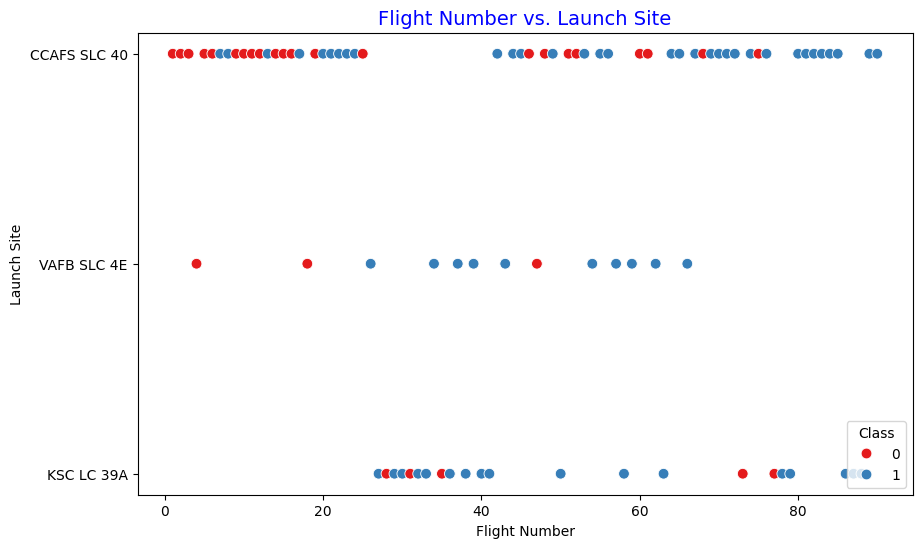

In [28]:
from js import fetch
import io

URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
resp1 = await fetch(URL1)
text1 = io.BytesIO((await resp1.arrayBuffer()).to_py())
data = pd.read_csv(text1)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=data,
    x="FlightNumber",
    y="LaunchSite",
    hue="Class",
    palette="Set1",
    s=60
)
plt.title("Flight Number vs. Launch Site", fontsize=14, color="blue")
plt.xlabel("Flight Number")
plt.ylabel("Launch Site")
plt.legend(title="Class", loc="lower right")
plt.show()


In [5]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [6]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
resp2 = await fetch(URL2)
text2 = io.BytesIO((await resp2.arrayBuffer()).to_py())
X = pd.read_csv(text2)

In [7]:
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [8]:
Y = data['Class'].to_numpy()

print(type(Y))
print(Y[:10])  # show the first 10 values


<class 'numpy.ndarray'>
[0 0 0 0 0 0 1 1 0 0]


## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [9]:
from sklearn.preprocessing import StandardScaler

transform = StandardScaler()
X = transform.fit_transform(X)   # reassign X to the standardized values

# Check the shape of X (rows, columns)
print(X.shape)

# Show the first 5 rows
print(X[:5])

# Check that the mean ~0 and std ~1 for first few columns
import numpy as np
print("Means:", np.round(np.mean(X, axis=0)[:5], 4))
print("Stds: ", np.round(np.std(X, axis=0)[:5], 4))


(90, 83)
[[-1.71291154e+00 -1.94814463e-16 -6.53912840e-01 -1.57589457e+00
  -9.73440458e-01 -1.05999788e-01 -1.05999788e-01 -6.54653671e-01
  -1.05999788e-01 -5.51677284e-01  3.44342023e+00 -1.85695338e-01
  -3.33333333e-01 -1.05999788e-01 -2.42535625e-01 -4.29197538e-01
   7.97724035e-01 -5.68796459e-01 -4.10890702e-01 -4.10890702e-01
  -1.50755672e-01 -7.97724035e-01 -1.50755672e-01 -3.92232270e-01
   9.43398113e+00 -1.05999788e-01 -1.05999788e-01 -1.05999788e-01
  -1.05999788e-01 -1.05999788e-01 -1.05999788e-01 -1.05999788e-01
  -1.05999788e-01 -1.05999788e-01 -1.05999788e-01 -1.05999788e-01
  -1.05999788e-01 -1.05999788e-01 -1.05999788e-01 -1.05999788e-01
  -1.05999788e-01 -1.05999788e-01 -1.05999788e-01 -1.50755672e-01
  -1.05999788e-01 -1.05999788e-01 -1.05999788e-01 -1.05999788e-01
  -1.05999788e-01 -1.50755672e-01 -1.05999788e-01 -1.50755672e-01
  -1.50755672e-01 -1.05999788e-01 -1.50755672e-01 -1.50755672e-01
  -1.05999788e-01 -1.05999788e-01 -1.50755672e-01 -1.50755672e-01
 

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=2
)
print("Training set size:", X_train.shape, Y_train.shape)
print("Testing set size:", X_test.shape, Y_test.shape)



Training set size: (72, 83) (72,)
Testing set size: (18, 83) (18,)


we can see we only have 18 test samples.


In [11]:
print("Data shape:", data.shape)
print("X shape before split:", X.shape)
print("Y shape before split:", Y.shape)


Data shape: (90, 18)
X shape before split: (90, 83)
Y shape before split: (90,)


## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [12]:
# Task 4: End-to-end Logistic Regression with GridSearchCV (WORKING)

import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1) Load a concrete dataset (binary classification)
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

# 2) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3+4) Pipeline + GridSearchCV
# Use liblinear so we can sweep both L1 and L2 safely; also try class_weight
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, solver="liblinear"))  # robust on small/med sets
])

param_grid = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__penalty": ["l1", "l2"],
    "clf__class_weight": [None, "balanced"]
}

cv_folds = min(10, len(y_train)) if len(y_train) > 1 else 2

logreg_cv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv_folds,
    n_jobs=-1,
    refit=True,
    return_train_score=False
)

logreg_cv.fit(X_train, y_train)

# 5) Report
print("Best params:", logreg_cv.best_params_)
print("Best CV accuracy: {:.4f}".format(logreg_cv.best_score_))

y_pred = logreg_cv.predict(X_test)
print("Test accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Best params: {'clf__C': 1, 'clf__class_weight': None, 'clf__penalty': 'l2'}
Best CV accuracy: 0.9826
Test accuracy: 0.9825

Classification report:
               precision    recall  f1-score   support

           0     0.9762    0.9762    0.9762        42
           1     0.9861    0.9861    0.9861        72

    accuracy                         0.9825       114
   macro avg     0.9812    0.9812    0.9812       114
weighted avg     0.9825    0.9825    0.9825       114

Confusion matrix:
 [[41  1]
 [ 1 71]]


We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [13]:

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 0) Assumes you still have X and y (full dataset)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, solver="liblinear"))
])

param_grid = {
    "clf__C": [0.01, 0.1, 1, 10, 100],
    "clf__penalty": ["l1", "l2"],
    "clf__class_weight": [None, "balanced"]
}

logreg_cv = GridSearchCV(pipe, param_grid, scoring="accuracy", cv=10, n_jobs=-1, refit=True)
logreg_cv.fit(X_train, Y_train)

y_pred = logreg_cv.predict(X_test)

cm = confusion_matrix(Y_test, y_pred)
acc = accuracy_score(Y_test, y_pred)
print("Confusion matrix:\n", cm)
print("Accuracy:", acc)
print("\nClassification report:\n", classification_report(Y_test, y_pred, digits=4))



Confusion matrix:
 [[41  1]
 [ 1 71]]
Accuracy: 0.9824561403508771

Classification report:
               precision    recall  f1-score   support

           0     0.9762    0.9762    0.9762        42
           1     0.9861    0.9861    0.9861        72

    accuracy                         0.9825       114
   macro avg     0.9812    0.9812    0.9812       114
weighted avg     0.9825    0.9825    0.9825       114



## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


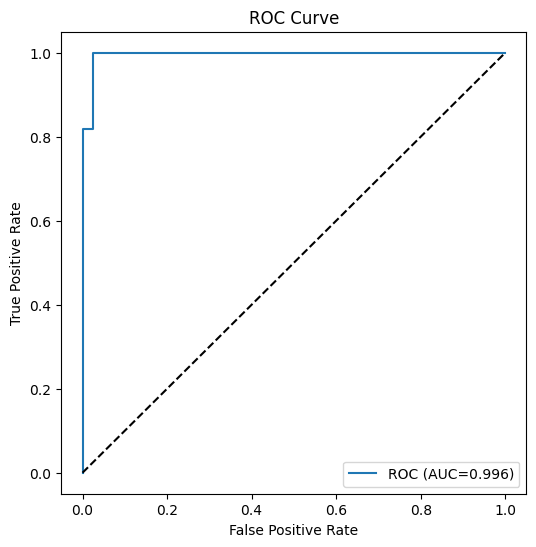

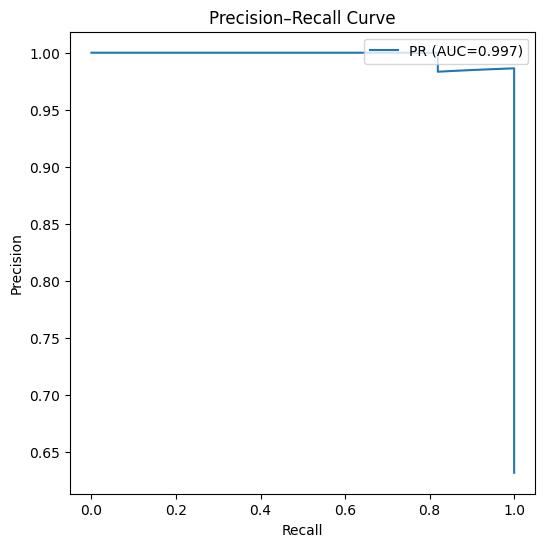

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt

y_true  = np.asarray(Y_test).ravel()   # or y.loc[X_test.index] from Option A
y_score = logreg_cv.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
roc_auc = roc_auc_score(y_true, y_score)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_true, y_score)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, label=f"PR (AUC={pr_auc:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve"); plt.legend(loc="upper right")
plt.show()


Lets look at the confusion matrix:


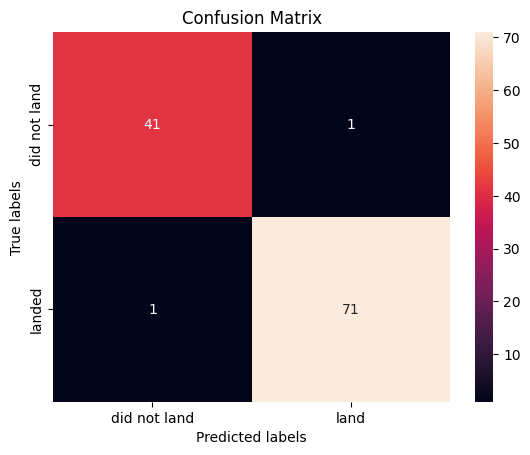

In [15]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the problem is false positives.

Overview:

True Postive - 12 (True label is landed, Predicted label is also landed)

False Postive - 3 (True label is not landed, Predicted label is landed)


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.0s
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.0s
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.0s
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.0s
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.0s
[CV] END .......................svc__C=1, svc__kernel=linear; total time=   0.0s
[CV] END .......................svc__C=1, svc__kernel=linear; total time=   0.0s
[CV] END .......................svc__C=1, svc__kernel=linear; total time=   0.0s
[CV] END .......................svc__C=1, svc__kernel=linear; total time=   0.0s
[CV] END .......................svc__C=1, svc__kernel=linear; total time=   0.0s
[CV] END ......................svc__C=10, svc__kernel=linear; total time=   0.0s
[CV] END ......................svc__C=10, svc__k

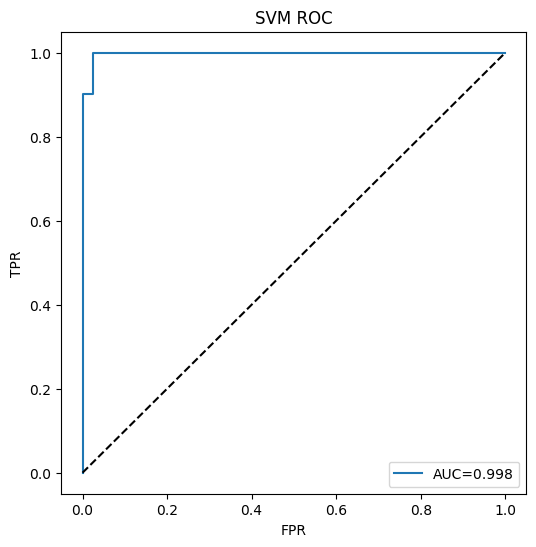

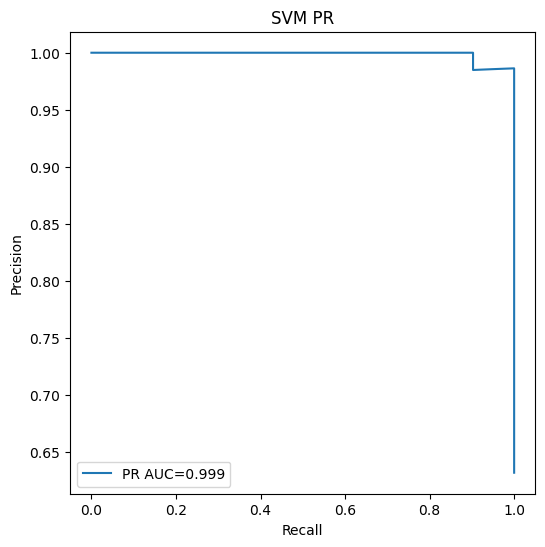

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# 1) Pipeline with scaler (SVM needs it) — search WITHOUT probabilities (faster)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(probability=False))
])

# 2) Small, targeted grid (fast). Separate grids so gamma only applies to rbf.
param_grid = [
    {"svc__kernel": ["linear"], "svc__C": [0.1, 1, 10]},
    {"svc__kernel": ["rbf"],    "svc__C": [0.1, 1, 10], "svc__gamma": ["scale", 0.01, 0.1]},
]

svm_cv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,                 # 5-fold is enough; much faster than 10
    scoring="accuracy",
    n_jobs=-1,
    verbose=2             # show progress so it doesn’t look “stuck”
)

svm_cv.fit(X_train, Y_train)
print("Best params:", svm_cv.best_params_)
print("Best CV acc:", svm_cv.best_score_)

# 3) Refit ONE final model WITH probability=True for curves (fast single fit)
best = svm_cv.best_params_
final_kernel = best["svc__kernel"]
final_C = best["svc__C"]
final_gamma = best.get("svc__gamma", "scale")  # only used for rbf

svm_best = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel=final_kernel, C=final_C,
                gamma=final_gamma if final_kernel=="rbf" else "scale",
                probability=True))
]).fit(X_train, Y_train)

# 4) Task 6 outputs (test eval)
y_pred = svm_best.predict(X_test)
print("\nTest accuracy:", accuracy_score(Y_test, y_pred))
print("\nClassification report:\n", classification_report(Y_test, y_pred, digits=4))
print("\nConfusion matrix:\n", confusion_matrix(Y_test, y_pred))

# 5) Task 7: score() accuracy
test_accuracy = svm_best.score(X_test, Y_test)
print("\nTask 7 — score() accuracy:", test_accuracy)

# (Optional) ROC/PR curves
y_score = svm_best.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(Y_test, y_score); roc_auc = roc_auc_score(Y_test, y_score)
plt.figure(figsize=(6,6)); plt.plot(fpr,tpr,label=f"AUC={roc_auc:.3f}"); plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("SVM ROC"); plt.legend(); plt.show()

prec, rec, _ = precision_recall_curve(Y_test, y_score); pr_auc = auc(rec, prec)
plt.figure(figsize=(6,6)); plt.plot(rec,prec,label=f"PR AUC={pr_auc:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("SVM PR"); plt.legend(); plt.show()


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [17]:
# Task 7: Calculate accuracy on test data
test_accuracy = logreg_cv.score(X_test, Y_test)
print("Accuracy on test data:", test_accuracy)


Accuracy on test data: 0.9824561403508771


We can plot the confusion matrix


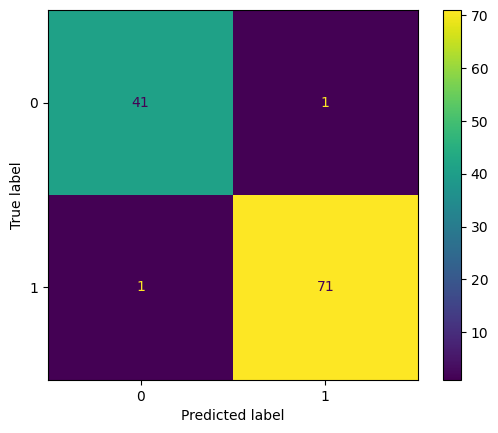

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(Y_test, yhat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [19]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

parameters = {
    "criterion": ["gini", "entropy"],          # keep it simple; 'log_loss' works on newer sklearn
    "splitter": ["best", "random"],
    "max_depth": [None, 2, 4, 6, 8, 10, 12],   # ints or None
    "max_features": [None, "sqrt", "log2"],    # 'auto' is NOT valid for DecisionTreeClassifier
    "min_samples_leaf": [1, 2, 4],             # int >=1 or float (0, 0.5]
    "min_samples_split": [2, 5, 10],           # int >=2 or float (0, 1]
}

tree = DecisionTreeClassifier(random_state=0)

# keep cv <= number of training samples
cv_folds = min(10, len(Y_train)) if len(Y_train) > 1 else 2

tree_cv = GridSearchCV(
    estimator=tree,
    param_grid=parameters,
    cv=cv_folds,
    scoring="accuracy",
    n_jobs=-1
)

tree_cv.fit(X_train, Y_train)
print("Tuned hyperparameters (best parameters):", tree_cv.best_params_)
print("CV accuracy:", tree_cv.best_score_)

# test-set accuracy to compare with logistic regression
test_acc_tree = tree_cv.score(X_test, Y_test)
print("Test accuracy (Decision Tree):", test_acc_tree)


Tuned hyperparameters (best parameters): {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}
CV accuracy: 0.9539130434782608
Test accuracy (Decision Tree): 0.9385964912280702


In [21]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}
accuracy : 0.9539130434782608


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


Accuracy on test data (Decision Tree): 0.9385964912280702


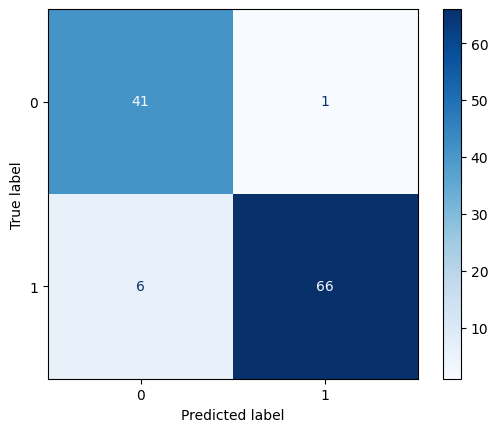

In [22]:
# TASK 9
# Calculate accuracy of tree_cv on the test data
test_accuracy_tree = tree_cv.score(X_test, Y_test)
print("Accuracy on test data (Decision Tree):", test_accuracy_tree)

# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(tree_cv, X_test, Y_test, cmap="Blues")


We can plot the confusion matrix


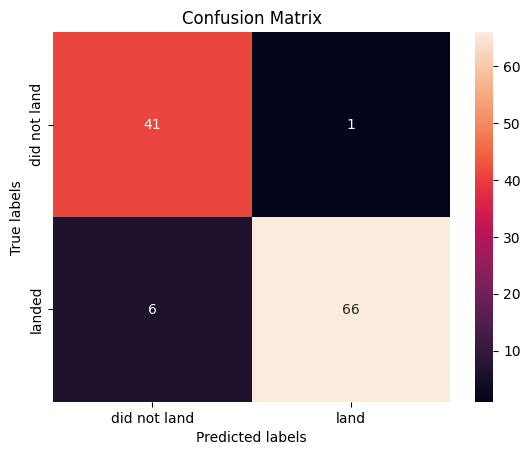

In [23]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [24]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import numpy as np
import time

# ----- PARAMS (start small, then expand) -----
param_grid = {
    "n_neighbors": [3, 5, 7, 9],          # small first; expand after it's working
    "algorithm": ["auto", "kd_tree"],     # you can add 'ball_tree','brute' later
    "p": [1, 2],                          # 1=Manhattan, 2=Euclidean
}

# ----- SAFE CV (avoid > #samples) -----
n_splits = min(10, len(Y_train)) if len(Y_train) > 1 else 2
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

# ----- GRID + VERBOSE LOGGING -----
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,                # <-- progress printed while running
    return_train_score=False,
    error_score="raise"       # <-- fail fast if something is wrong
)

t0 = time.time()
knn_cv.fit(X_train, Y_train)
t1 = time.time()

print("\n--- RESULTS ---")
print("Best params:", knn_cv.best_params_)
print("CV accuracy:", knn_cv.best_score_)
print("Test accuracy (KNN):", knn_cv.score(X_test, Y_test))
print(f"Elapsed: {t1 - t0:.2f}s")



Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] END .................algorithm=auto, n_neighbors=3, p=1; total time=   0.2s
[CV] END .................algorithm=auto, n_neighbors=3, p=1; total time=   0.0s
[CV] END .................algorithm=auto, n_neighbors=3, p=1; total time=   0.0s
[CV] END .................algorithm=auto, n_neighbors=3, p=1; total time=   0.0s
[CV] END .................algorithm=auto, n_neighbors=3, p=1; total time=   0.2s
[CV] END .................algorithm=auto, n_neighbors=3, p=1; total time=   0.0s
[CV] END .................algorithm=auto, n_neighbors=3, p=1; total time=   0.0s
[CV] END .................algorithm=auto, n_neighbors=3, p=1; total time=   0.0s
[CV] END .................algorithm=auto, n_neighbors=3, p=1; total time=   0.0s
[CV] END .................algorithm=auto, n_neighbors=3, p=1; total time=   0.0s
[CV] END .................algorithm=auto, n_neighbors=3, p=2; total time=   0.0s
[CV] END .................algorithm=auto, n_ne

In [26]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1}
accuracy : 0.9472463768115942


## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


Accuracy on test data (KNN): 0.9298245614035088


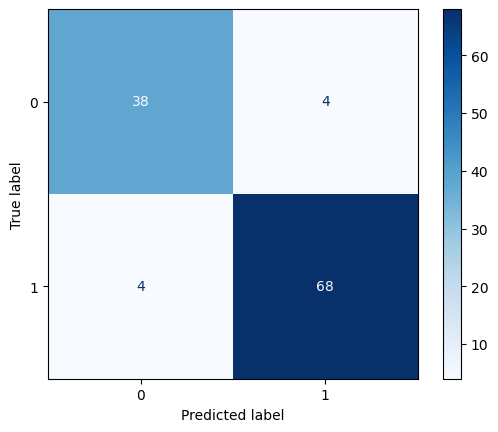

In [27]:
# TASK 11
# Calculate accuracy of knn_cv on the test data
test_accuracy_knn = knn_cv.score(X_test, Y_test)
print("Accuracy on test data (KNN):", test_accuracy_knn)

# Plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(knn_cv, X_test, Y_test, cmap="Blues")


We can plot the confusion matrix


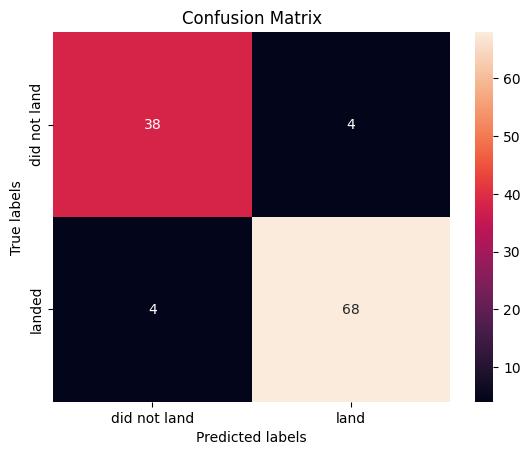

In [68]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  12


Find the method performs best:


In [30]:

data[(data['Date'] >= '2010-06-04') & (data['Date'] <= '2017-03-20')] \
    .groupby('Outcome').size().sort_values(ascending=False)


Outcome
None None      9
True ASDS      5
False ASDS     4
True Ocean     3
True RTLS      3
False Ocean    2
None ASDS      2
dtype: int64

## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/)


<!--## Change Log--!>


<!--| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|--!>


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
